# Fun with Conditional Variational Autoencoders

This is a starter kernel to understand the main principles of conditional variational autoencoders. PyTorch will be used for modelling.

### **Please, give this kernel an upvote if it's helpful for you.**

You can find explanation of the vanilla and variational autoencoders in the following notebook:

* [Fun with Variational Autoencoders](https://www.kaggle.com/averkij/variational-autoencoder-and-faces-generation/edit/run/28076587)

In this kernel we will discuss the conditional variation of the autoencoder and build a model, train it and analyse the latent space with t-SNE technique.

![architecture](https://www.mdpi.com/sensors/sensors-19-02528/article_deploy/html/images/sensors-19-02528-g002.png)


# The dataset

We will use the MNIST dataset because it's simple and small. You can fork this notebook and experiment with the dataset you like. Fashion MNIST, etc.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox, TextArea
import matplotlib
import numpy as np
import pandas as pd
import torch
import torchvision
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils import data
import torch.nn.functional as F
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import save_image
from sklearn.model_selection import train_test_split
from tqdm import tqdm, tqdm_notebook
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print('Training on',DEVICE)

Training on cuda


In [2]:
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
batch_size = 128
learning_rate = 0.005
input_size = 28*28
hidden_size = 12
labels_length = 10

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [5]:
dataset = MNIST('./data', transform=transform, download=True)
train_data, test_data = data.random_split(dataset, (50000,10000))

train_dataset = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_dataset = DataLoader(test_data, batch_size=batch_size, shuffle=True)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


In [6]:
#helper functions
def one_hot(x, max_x):
    return torch.eye(max_x + 1)[x]

def plot_gallery(images, h, w, n_row=3, n_col=6):
    plt.figure(figsize=(2 * n_col, 2 * n_row))
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.axis("off")
        plt.imshow(images[i].reshape(h, w), cmap = matplotlib.cm.binary)
    plt.show()
    
def plot_loss(history):
    loss, val_loss = zip(*history)
    plt.figure(figsize=(15, 9))
    plt.plot(loss, label="train_loss")
    plt.plot(val_loss, label="val_loss")
    plt.legend(loc='best')
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.show()

In [7]:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(input_size + labels_length, 64),
            #nn.ReLU(True),
            #nn.Linear(128, 64),
            nn.ReLU(True),
            nn.Linear(64, hidden_size))
             
        self.decoder = nn.Sequential(
            nn.Linear(hidden_size + labels_length, 64),
            nn.ReLU(True),
            #nn.Linear(64, 128),
            #nn.ReLU(True),
            nn.Linear(64, input_size),
            nn.Tanh())

    def encode(self, x, labels):
        x = x.view(-1, 1*28*28)
        x = torch.cat((x,labels),dim=1)
        return self.encoder(x)
    
    def decode(self, x, labels):
        x = torch.cat((x,labels),dim=1)
        return self.decoder(x)

    def forward(self, x, labels):
        x = self.encode(x,labels)
        x = self.decode(x,labels)
        return x

In [8]:
model = autoencoder().to(DEVICE)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [9]:
def fit_epoch(model, train_loader, criterion, optimizer, is_cvae):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = one_hot(labels,9).to(DEVICE)
        optimizer.zero_grad()
        if is_cvae:
            outputs, mu, logvar = model(inputs,labels)
            loss = vae_loss_fn(inputs.view(-1,28*28), outputs, mu, logvar)
            loss.backward()
        else:
            outputs = model(inputs,labels)
            loss = criterion(outputs, inputs.view(-1,28*28))
            loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    return train_loss
  
def eval_epoch(model, val_loader, criterion, is_cvae):
    model.eval()
    running_loss = 0.0
    processed_size = 0
    inp,out = [],[]
    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = one_hot(labels,9).to(DEVICE)

        with torch.set_grad_enabled(False):
            if is_cvae:
                outputs, mu, logvar = model(inputs,labels)
                loss = vae_loss_fn(inputs.view(-1,28*28), outputs, mu, logvar)
                loss.backward()
            else:
                outputs = model(inputs,labels)
                loss = criterion(outputs, inputs.view(-1,28*28))
                inp,out = inputs, outputs

        running_loss += loss.item() * inputs.size(0)
        processed_size += inputs.size(0)
        
    with torch.set_grad_enabled(False):
        plot_gallery([inp[0].cpu(),out[0].cpu()],28,28,1,2)

    val_loss = running_loss / processed_size
    return val_loss
  
def train(train_loader, val_loader, model, epochs, batch_size, is_cvae=False):
    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} val_loss {v_loss:0.4f}"
    with tqdm(desc="epoch", total=epochs) as pbar_outer:        
        opt = torch.optim.Adam(model.parameters())
        criterion = nn.MSELoss()
        for epoch in range(epochs):
            train_loss = fit_epoch(model, train_loader, criterion, opt, is_cvae)
            print("loss", train_loss)            
            val_loss = eval_epoch(model, val_loader, criterion, is_cvae)
            history.append((train_loss, val_loss))            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss, v_loss=val_loss))            
    return history

epoch:   0%|          | 0/200 [00:00<?, ?it/s]

loss 0.19297191811084746


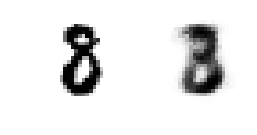

epoch:   0%|          | 1/200 [00:12<42:51, 12.92s/it]


Epoch 001 train_loss: 0.1930 val_loss 0.1158
loss 0.1061476742196083


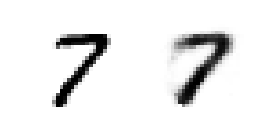

epoch:   1%|          | 2/200 [00:24<41:42, 12.64s/it]


Epoch 002 train_loss: 0.1061 val_loss 0.1001
loss 0.09722605629444123


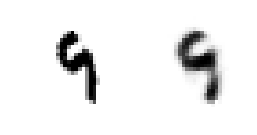

epoch:   2%|▏         | 3/200 [00:36<40:04, 12.20s/it]


Epoch 003 train_loss: 0.0972 val_loss 0.0948
loss 0.09226338931322098


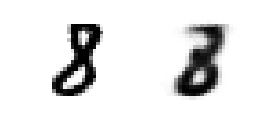

epoch:   2%|▏         | 4/200 [00:47<38:46, 11.87s/it]


Epoch 004 train_loss: 0.0923 val_loss 0.0906
loss 0.08917587899446487


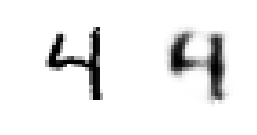

epoch:   2%|▎         | 5/200 [00:58<37:54, 11.66s/it]


Epoch 005 train_loss: 0.0892 val_loss 0.0886
loss 0.08690706946611404


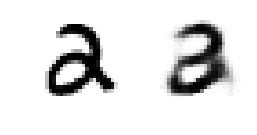

epoch:   3%|▎         | 6/200 [01:10<38:32, 11.92s/it]


Epoch 006 train_loss: 0.0869 val_loss 0.0862
loss 0.08501052361249924


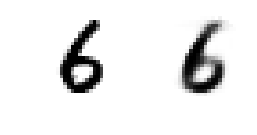

epoch:   4%|▎         | 7/200 [01:22<38:13, 11.88s/it]


Epoch 007 train_loss: 0.0850 val_loss 0.0845
loss 0.08315612380981445


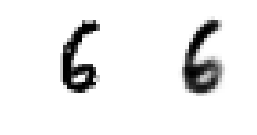

epoch:   4%|▍         | 8/200 [01:33<37:24, 11.69s/it]


Epoch 008 train_loss: 0.0832 val_loss 0.0830
loss 0.08181245424747467


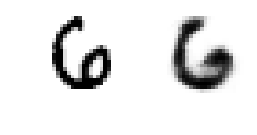

epoch:   4%|▍         | 9/200 [01:45<36:46, 11.55s/it]


Epoch 009 train_loss: 0.0818 val_loss 0.0816
loss 0.08052178816080094


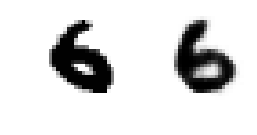

epoch:   5%|▌         | 10/200 [01:56<36:30, 11.53s/it]


Epoch 010 train_loss: 0.0805 val_loss 0.0807
loss 0.07951997558116913


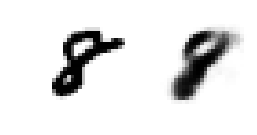

epoch:   6%|▌         | 11/200 [02:09<37:08, 11.79s/it]


Epoch 011 train_loss: 0.0795 val_loss 0.0800
loss 0.07865129850149155


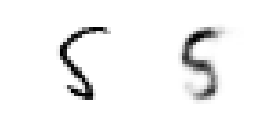

epoch:   6%|▌         | 12/200 [02:21<37:14, 11.88s/it]


Epoch 012 train_loss: 0.0787 val_loss 0.0789
loss 0.07784290399551391


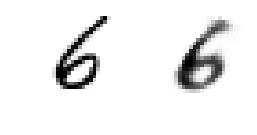

epoch:   6%|▋         | 13/200 [02:32<36:36, 11.75s/it]


Epoch 013 train_loss: 0.0778 val_loss 0.0782
loss 0.07712155649662018


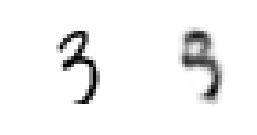

epoch:   7%|▋         | 14/200 [02:43<35:56, 11.60s/it]


Epoch 014 train_loss: 0.0771 val_loss 0.0776
loss 0.07650937279701232


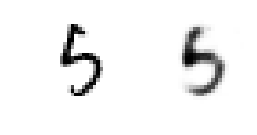

epoch:   8%|▊         | 15/200 [02:55<35:40, 11.57s/it]


Epoch 015 train_loss: 0.0765 val_loss 0.0773
loss 0.07583478358507156


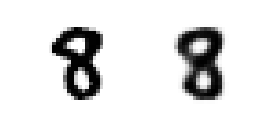

epoch:   8%|▊         | 16/200 [03:07<36:06, 11.77s/it]


Epoch 016 train_loss: 0.0758 val_loss 0.0765
loss 0.07529502551555634


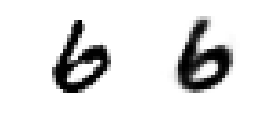

epoch:   8%|▊         | 17/200 [03:19<35:53, 11.77s/it]


Epoch 017 train_loss: 0.0753 val_loss 0.0761
loss 0.07481402490377426


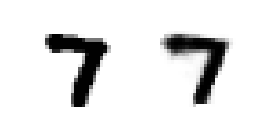

epoch:   9%|▉         | 18/200 [03:30<35:30, 11.71s/it]


Epoch 018 train_loss: 0.0748 val_loss 0.0754
loss 0.07428886825323106


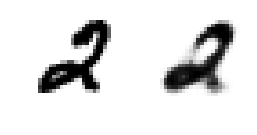

epoch:  10%|▉         | 19/200 [03:42<34:50, 11.55s/it]


Epoch 019 train_loss: 0.0743 val_loss 0.0748
loss 0.07386999528169631


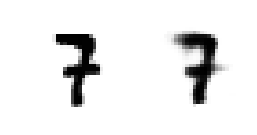

epoch:  10%|█         | 20/200 [03:53<34:25, 11.48s/it]


Epoch 020 train_loss: 0.0739 val_loss 0.0745
loss 0.07340051596403122


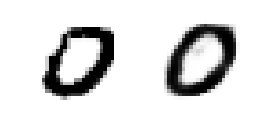

epoch:  10%|█         | 21/200 [04:05<35:03, 11.75s/it]


Epoch 021 train_loss: 0.0734 val_loss 0.0739
loss 0.07300433170318603


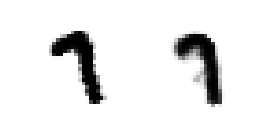

epoch:  11%|█         | 22/200 [04:17<34:57, 11.78s/it]


Epoch 022 train_loss: 0.0730 val_loss 0.0737
loss 0.07255283257484436


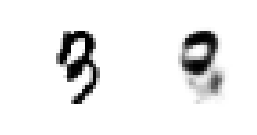

epoch:  12%|█▏        | 23/200 [04:29<34:33, 11.72s/it]


Epoch 023 train_loss: 0.0726 val_loss 0.0733
loss 0.0721610888338089


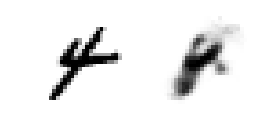

epoch:  12%|█▏        | 24/200 [04:40<34:16, 11.68s/it]


Epoch 024 train_loss: 0.0722 val_loss 0.0729
loss 0.07179531936645508


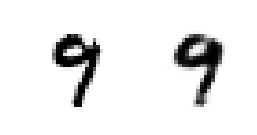

epoch:  12%|█▎        | 25/200 [04:52<33:43, 11.56s/it]


Epoch 025 train_loss: 0.0718 val_loss 0.0726
loss 0.07140980166196823


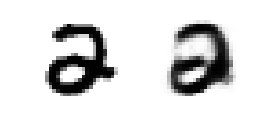

epoch:  13%|█▎        | 26/200 [05:03<33:43, 11.63s/it]


Epoch 026 train_loss: 0.0714 val_loss 0.0721
loss 0.07104629637002945


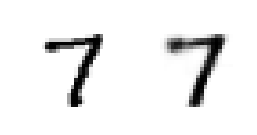

epoch:  14%|█▎        | 27/200 [05:16<34:32, 11.98s/it]


Epoch 027 train_loss: 0.0710 val_loss 0.0717
loss 0.07069793744564057


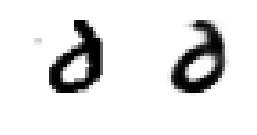

epoch:  14%|█▍        | 28/200 [05:28<33:50, 11.81s/it]


Epoch 028 train_loss: 0.0707 val_loss 0.0716
loss 0.07045175437211991


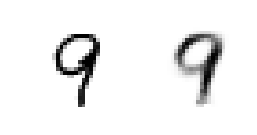

epoch:  14%|█▍        | 29/200 [05:39<33:08, 11.63s/it]


Epoch 029 train_loss: 0.0705 val_loss 0.0712
loss 0.07014488229513169


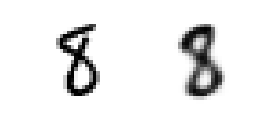

epoch:  15%|█▌        | 30/200 [05:50<32:29, 11.47s/it]


Epoch 030 train_loss: 0.0701 val_loss 0.0711
loss 0.06984476955890656


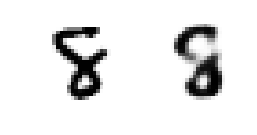

epoch:  16%|█▌        | 31/200 [06:01<32:27, 11.52s/it]


Epoch 031 train_loss: 0.0698 val_loss 0.0708
loss 0.06958537600278854


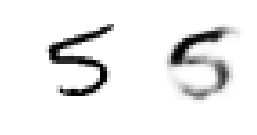

epoch:  16%|█▌        | 32/200 [06:14<32:47, 11.71s/it]


Epoch 032 train_loss: 0.0696 val_loss 0.0702
loss 0.0692823172044754


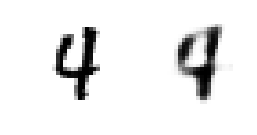

epoch:  16%|█▋        | 33/200 [06:25<32:26, 11.66s/it]


Epoch 033 train_loss: 0.0693 val_loss 0.0700
loss 0.06905180302619934


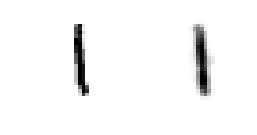

epoch:  17%|█▋        | 34/200 [06:36<31:45, 11.48s/it]


Epoch 034 train_loss: 0.0691 val_loss 0.0698
loss 0.06879926803827285


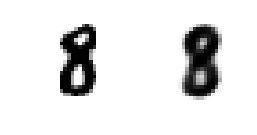

epoch:  18%|█▊        | 35/200 [06:48<31:24, 11.42s/it]


Epoch 035 train_loss: 0.0688 val_loss 0.0698
loss 0.06858046940565109


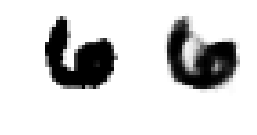

epoch:  18%|█▊        | 36/200 [06:59<31:22, 11.48s/it]


Epoch 036 train_loss: 0.0686 val_loss 0.0694
loss 0.0683686746954918


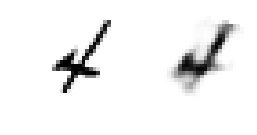

epoch:  18%|█▊        | 37/200 [07:11<31:33, 11.62s/it]


Epoch 037 train_loss: 0.0684 val_loss 0.0692
loss 0.06820793868541718


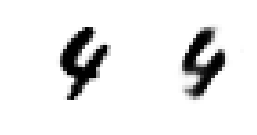

epoch:  19%|█▉        | 38/200 [07:23<31:41, 11.74s/it]


Epoch 038 train_loss: 0.0682 val_loss 0.0689
loss 0.06793530176639558


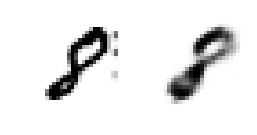

epoch:  20%|█▉        | 39/200 [07:34<31:11, 11.62s/it]


Epoch 039 train_loss: 0.0679 val_loss 0.0690
loss 0.06776595652103425


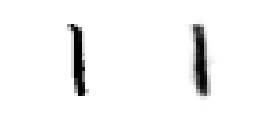

epoch:  20%|██        | 40/200 [07:46<30:39, 11.50s/it]


Epoch 040 train_loss: 0.0678 val_loss 0.0688
loss 0.06764497335672379


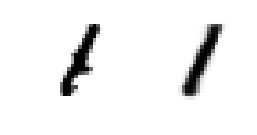

epoch:  20%|██        | 41/200 [07:57<30:21, 11.46s/it]


Epoch 041 train_loss: 0.0676 val_loss 0.0685
loss 0.06743783588409424


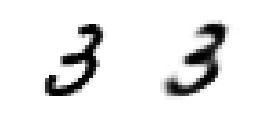

epoch:  21%|██        | 42/200 [08:09<30:52, 11.72s/it]


Epoch 042 train_loss: 0.0674 val_loss 0.0682
loss 0.06725284739971162


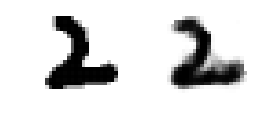

epoch:  22%|██▏       | 43/200 [08:21<30:47, 11.77s/it]


Epoch 043 train_loss: 0.0673 val_loss 0.0683
loss 0.0670820006966591


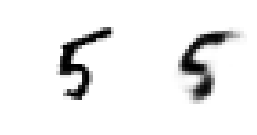

epoch:  22%|██▏       | 44/200 [08:33<30:12, 11.62s/it]


Epoch 044 train_loss: 0.0671 val_loss 0.0680
loss 0.06695346945047378


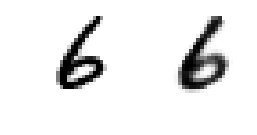

epoch:  22%|██▎       | 45/200 [08:44<29:37, 11.47s/it]


Epoch 045 train_loss: 0.0670 val_loss 0.0679
loss 0.06678287424445152


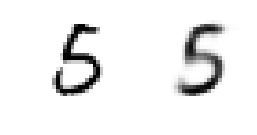

epoch:  23%|██▎       | 46/200 [08:55<29:23, 11.45s/it]


Epoch 046 train_loss: 0.0668 val_loss 0.0677
loss 0.0666290767288208


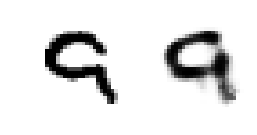

epoch:  24%|██▎       | 47/200 [09:07<29:50, 11.70s/it]


Epoch 047 train_loss: 0.0666 val_loss 0.0675
loss 0.06643319082021713


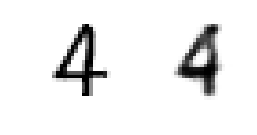

epoch:  24%|██▍       | 48/200 [09:19<29:43, 11.74s/it]


Epoch 048 train_loss: 0.0664 val_loss 0.0676
loss 0.06634248543262482


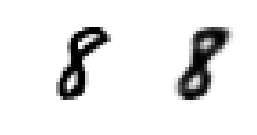

epoch:  24%|██▍       | 49/200 [09:31<29:20, 11.66s/it]


Epoch 049 train_loss: 0.0663 val_loss 0.0672
loss 0.06621056341409683


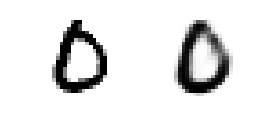

epoch:  25%|██▌       | 50/200 [09:42<29:04, 11.63s/it]


Epoch 050 train_loss: 0.0662 val_loss 0.0675
loss 0.06610637707710267


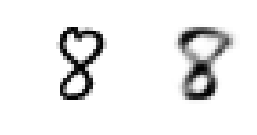

epoch:  26%|██▌       | 51/200 [09:53<28:34, 11.51s/it]


Epoch 051 train_loss: 0.0661 val_loss 0.0674
loss 0.06592257791042327


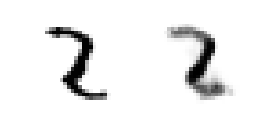

epoch:  26%|██▌       | 52/200 [10:06<28:55, 11.73s/it]


Epoch 052 train_loss: 0.0659 val_loss 0.0671
loss 0.0658348984670639


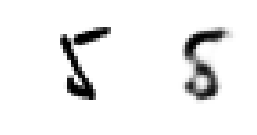

epoch:  26%|██▋       | 53/200 [10:18<28:51, 11.78s/it]


Epoch 053 train_loss: 0.0658 val_loss 0.0668
loss 0.06570535015583039


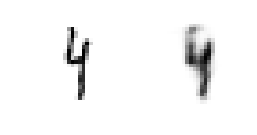

epoch:  27%|██▋       | 54/200 [10:29<28:30, 11.71s/it]


Epoch 054 train_loss: 0.0657 val_loss 0.0670
loss 0.06554585821866989


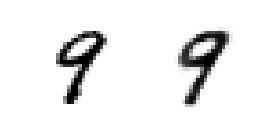

epoch:  28%|██▊       | 55/200 [10:41<28:10, 11.66s/it]


Epoch 055 train_loss: 0.0655 val_loss 0.0667
loss 0.06548547545075417


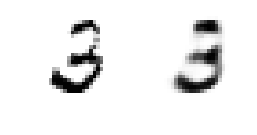

epoch:  28%|██▊       | 56/200 [10:52<27:43, 11.55s/it]


Epoch 056 train_loss: 0.0655 val_loss 0.0665
loss 0.06532443940401077


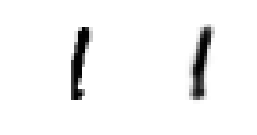

epoch:  28%|██▊       | 57/200 [11:04<27:59, 11.75s/it]


Epoch 057 train_loss: 0.0653 val_loss 0.0666
loss 0.06523296966075898


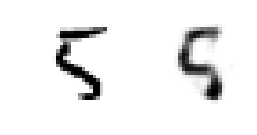

epoch:  29%|██▉       | 58/200 [11:16<27:51, 11.77s/it]


Epoch 058 train_loss: 0.0652 val_loss 0.0663
loss 0.06511686304807662


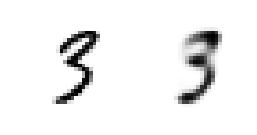

epoch:  30%|██▉       | 59/200 [11:28<27:37, 11.76s/it]


Epoch 059 train_loss: 0.0651 val_loss 0.0662
loss 0.06499669005513191


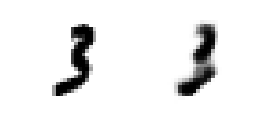

epoch:  30%|███       | 60/200 [11:39<27:08, 11.63s/it]


Epoch 060 train_loss: 0.0650 val_loss 0.0661
loss 0.0648783214700222


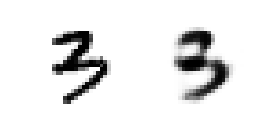

epoch:  30%|███       | 61/200 [11:50<26:43, 11.54s/it]


Epoch 061 train_loss: 0.0649 val_loss 0.0658
loss 0.06480917661190033


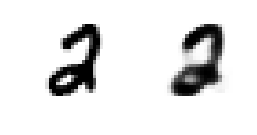

epoch:  31%|███       | 62/200 [12:02<26:51, 11.68s/it]


Epoch 062 train_loss: 0.0648 val_loss 0.0659
loss 0.06470759900331498


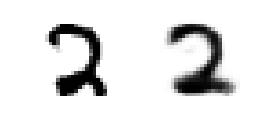

epoch:  32%|███▏      | 63/200 [12:14<26:52, 11.77s/it]


Epoch 063 train_loss: 0.0647 val_loss 0.0656
loss 0.06458793336629867


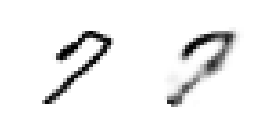

epoch:  32%|███▏      | 64/200 [12:26<26:37, 11.75s/it]


Epoch 064 train_loss: 0.0646 val_loss 0.0659
loss 0.0644774073600769


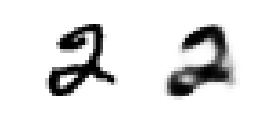

epoch:  32%|███▎      | 65/200 [12:38<26:24, 11.74s/it]


Epoch 065 train_loss: 0.0645 val_loss 0.0657
loss 0.06438899028301238


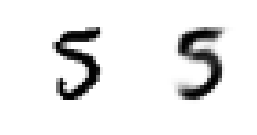

epoch:  33%|███▎      | 66/200 [12:49<25:56, 11.61s/it]


Epoch 066 train_loss: 0.0644 val_loss 0.0656
loss 0.06429611624479294


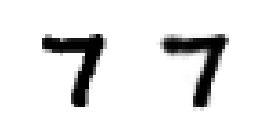

epoch:  34%|███▎      | 67/200 [13:01<26:02, 11.75s/it]


Epoch 067 train_loss: 0.0643 val_loss 0.0656
loss 0.06416290573596954


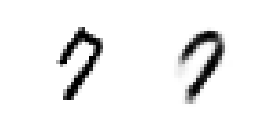

epoch:  34%|███▍      | 68/200 [13:13<25:55, 11.78s/it]


Epoch 068 train_loss: 0.0642 val_loss 0.0654
loss 0.064087213203907


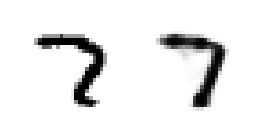

epoch:  34%|███▍      | 69/200 [13:25<25:52, 11.85s/it]


Epoch 069 train_loss: 0.0641 val_loss 0.0652
loss 0.06397662381529808


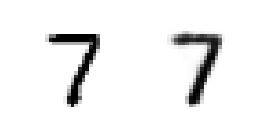

epoch:  35%|███▌      | 70/200 [13:36<25:22, 11.71s/it]


Epoch 070 train_loss: 0.0640 val_loss 0.0650
loss 0.06394775859951973


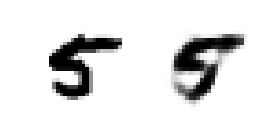

epoch:  36%|███▌      | 71/200 [13:48<24:55, 11.60s/it]


Epoch 071 train_loss: 0.0639 val_loss 0.0648
loss 0.0638060722899437


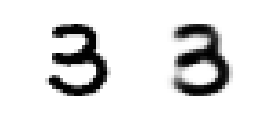

epoch:  36%|███▌      | 72/200 [14:00<24:55, 11.68s/it]


Epoch 072 train_loss: 0.0638 val_loss 0.0647
loss 0.0636998876285553


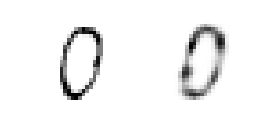

epoch:  36%|███▋      | 73/200 [14:12<24:58, 11.80s/it]


Epoch 073 train_loss: 0.0637 val_loss 0.0649
loss 0.06368395885229111


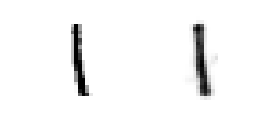

epoch:  37%|███▋      | 74/200 [14:24<24:48, 11.81s/it]


Epoch 074 train_loss: 0.0637 val_loss 0.0648
loss 0.06355989778280258


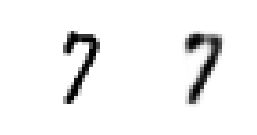

epoch:  38%|███▊      | 75/200 [14:35<24:24, 11.72s/it]


Epoch 075 train_loss: 0.0636 val_loss 0.0645
loss 0.06348319414258004


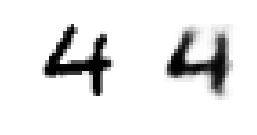

epoch:  38%|███▊      | 76/200 [14:46<24:00, 11.62s/it]


Epoch 076 train_loss: 0.0635 val_loss 0.0645
loss 0.06338573406219482


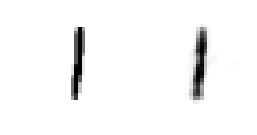

epoch:  38%|███▊      | 77/200 [14:58<23:36, 11.52s/it]


Epoch 077 train_loss: 0.0634 val_loss 0.0645
loss 0.06330948112726212


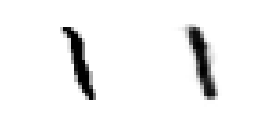

epoch:  39%|███▉      | 78/200 [15:10<24:07, 11.86s/it]


Epoch 078 train_loss: 0.0633 val_loss 0.0644
loss 0.06321200625419617


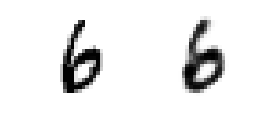

epoch:  40%|███▉      | 79/200 [15:22<23:56, 11.87s/it]


Epoch 079 train_loss: 0.0632 val_loss 0.0643
loss 0.06316862126350403


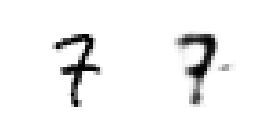

epoch:  40%|████      | 80/200 [15:34<23:31, 11.76s/it]


Epoch 080 train_loss: 0.0632 val_loss 0.0644
loss 0.0630735720705986


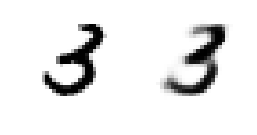

epoch:  40%|████      | 81/200 [15:45<23:07, 11.66s/it]


Epoch 081 train_loss: 0.0631 val_loss 0.0641
loss 0.06301283408164977


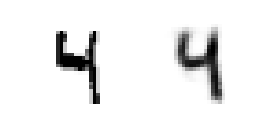

epoch:  41%|████      | 82/200 [15:56<22:36, 11.50s/it]


Epoch 082 train_loss: 0.0630 val_loss 0.0645
loss 0.0629489165353775


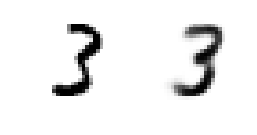

epoch:  42%|████▏     | 83/200 [16:09<22:53, 11.74s/it]


Epoch 083 train_loss: 0.0629 val_loss 0.0640
loss 0.06287186659574509


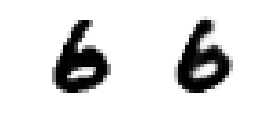

epoch:  42%|████▏     | 84/200 [16:21<22:47, 11.79s/it]


Epoch 084 train_loss: 0.0629 val_loss 0.0638
loss 0.06283000985622406


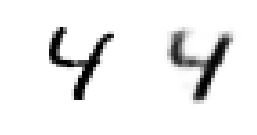

epoch:  42%|████▎     | 85/200 [16:32<22:20, 11.65s/it]


Epoch 085 train_loss: 0.0628 val_loss 0.0639
loss 0.06276882214188576


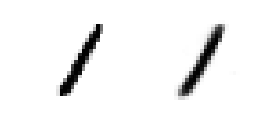

epoch:  43%|████▎     | 86/200 [16:43<21:53, 11.52s/it]


Epoch 086 train_loss: 0.0628 val_loss 0.0638
loss 0.0626595694565773


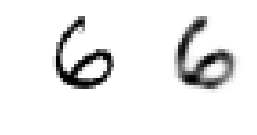

epoch:  44%|████▎     | 87/200 [16:55<21:40, 11.51s/it]


Epoch 087 train_loss: 0.0627 val_loss 0.0637
loss 0.06258238085508347


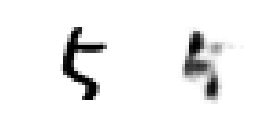

epoch:  44%|████▍     | 88/200 [17:07<21:53, 11.72s/it]


Epoch 088 train_loss: 0.0626 val_loss 0.0639
loss 0.06254505064725877


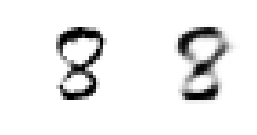

epoch:  44%|████▍     | 89/200 [17:19<21:43, 11.75s/it]


Epoch 089 train_loss: 0.0625 val_loss 0.0634
loss 0.062487937223911286


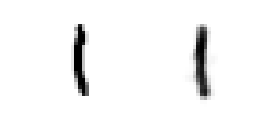

epoch:  45%|████▌     | 90/200 [17:30<21:26, 11.70s/it]


Epoch 090 train_loss: 0.0625 val_loss 0.0637
loss 0.062411661170721056


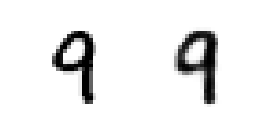

epoch:  46%|████▌     | 91/200 [17:41<21:02, 11.58s/it]


Epoch 091 train_loss: 0.0624 val_loss 0.0635
loss 0.062317605907917024


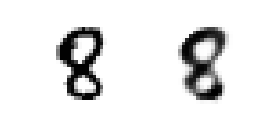

epoch:  46%|████▌     | 92/200 [17:53<20:43, 11.51s/it]


Epoch 092 train_loss: 0.0623 val_loss 0.0635
loss 0.062280461304187774


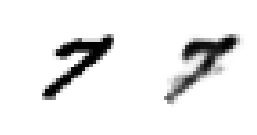

epoch:  46%|████▋     | 93/200 [18:05<20:52, 11.71s/it]


Epoch 093 train_loss: 0.0623 val_loss 0.0632
loss 0.06218336674451828


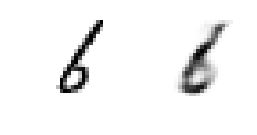

epoch:  47%|████▋     | 94/200 [18:17<20:39, 11.69s/it]


Epoch 094 train_loss: 0.0622 val_loss 0.0631
loss 0.06214636189699173


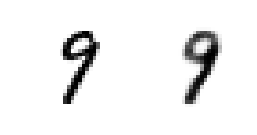

epoch:  48%|████▊     | 95/200 [18:28<20:19, 11.62s/it]


Epoch 095 train_loss: 0.0621 val_loss 0.0632
loss 0.062100919079780575


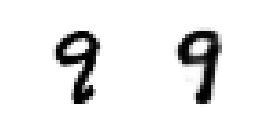

epoch:  48%|████▊     | 96/200 [18:39<19:53, 11.47s/it]


Epoch 096 train_loss: 0.0621 val_loss 0.0634
loss 0.0620389009988308


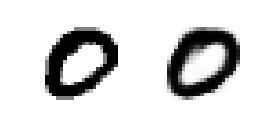

epoch:  48%|████▊     | 97/200 [18:51<19:39, 11.45s/it]


Epoch 097 train_loss: 0.0620 val_loss 0.0634
loss 0.06195386350989342


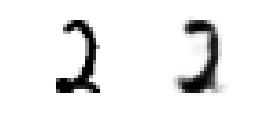

epoch:  49%|████▉     | 98/200 [19:02<19:34, 11.52s/it]


Epoch 098 train_loss: 0.0620 val_loss 0.0630
loss 0.061934177227020264


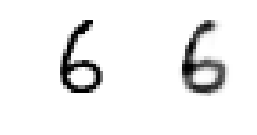

epoch:  50%|████▉     | 99/200 [19:14<19:42, 11.70s/it]


Epoch 099 train_loss: 0.0619 val_loss 0.0629
loss 0.06190467670798302


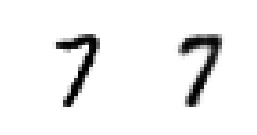

epoch:  50%|█████     | 100/200 [19:26<19:26, 11.67s/it]


Epoch 100 train_loss: 0.0619 val_loss 0.0629
loss 0.06176946540117264


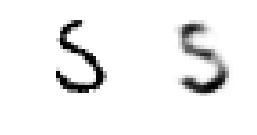

epoch:  50%|█████     | 101/200 [19:37<18:58, 11.50s/it]


Epoch 101 train_loss: 0.0618 val_loss 0.0627
loss 0.061817673437595366


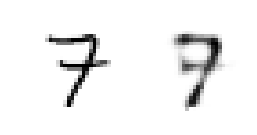

epoch:  51%|█████     | 102/200 [19:48<18:35, 11.38s/it]


Epoch 102 train_loss: 0.0618 val_loss 0.0630
loss 0.061728731417655947


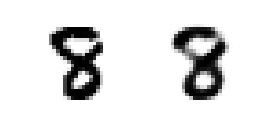

epoch:  52%|█████▏    | 103/200 [20:00<18:32, 11.47s/it]


Epoch 103 train_loss: 0.0617 val_loss 0.0628
loss 0.06166090373277664


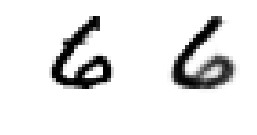

epoch:  52%|█████▏    | 104/200 [20:12<18:29, 11.56s/it]


Epoch 104 train_loss: 0.0617 val_loss 0.0627
loss 0.06163058849692345


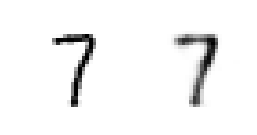

epoch:  52%|█████▎    | 105/200 [20:24<18:26, 11.65s/it]


Epoch 105 train_loss: 0.0616 val_loss 0.0628
loss 0.06158996551275253


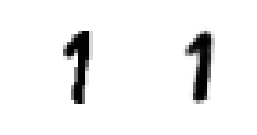

epoch:  53%|█████▎    | 106/200 [20:35<18:03, 11.53s/it]


Epoch 106 train_loss: 0.0616 val_loss 0.0628
loss 0.06153674235224724


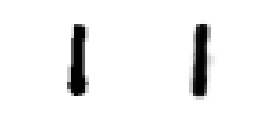

epoch:  54%|█████▎    | 107/200 [20:46<17:40, 11.40s/it]


Epoch 107 train_loss: 0.0615 val_loss 0.0629
loss 0.06151057628631592


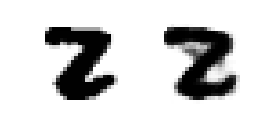

epoch:  54%|█████▍    | 108/200 [20:57<17:25, 11.37s/it]


Epoch 108 train_loss: 0.0615 val_loss 0.0625
loss 0.0614145115172863


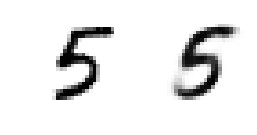

epoch:  55%|█████▍    | 109/200 [21:09<17:36, 11.61s/it]


Epoch 109 train_loss: 0.0614 val_loss 0.0626
loss 0.061400519912242886


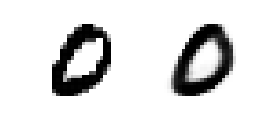

epoch:  55%|█████▌    | 110/200 [21:21<17:27, 11.64s/it]


Epoch 110 train_loss: 0.0614 val_loss 0.0626
loss 0.06138156526684761


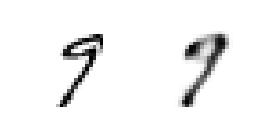

epoch:  56%|█████▌    | 111/200 [21:32<17:04, 11.51s/it]


Epoch 111 train_loss: 0.0614 val_loss 0.0629
loss 0.06133791039943695


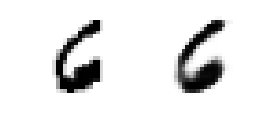

epoch:  56%|█████▌    | 112/200 [21:44<16:49, 11.47s/it]


Epoch 112 train_loss: 0.0613 val_loss 0.0626
loss 0.06128363086462021


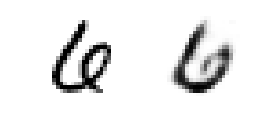

epoch:  56%|█████▋    | 113/200 [21:55<16:29, 11.38s/it]


Epoch 113 train_loss: 0.0613 val_loss 0.0623
loss 0.061225352127552035


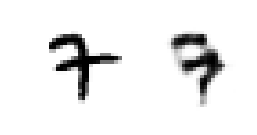

epoch:  57%|█████▋    | 114/200 [22:07<16:37, 11.60s/it]


Epoch 114 train_loss: 0.0612 val_loss 0.0622
loss 0.061221397902965546


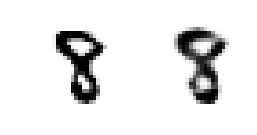

epoch:  57%|█████▊    | 115/200 [22:19<16:32, 11.67s/it]


Epoch 115 train_loss: 0.0612 val_loss 0.0623
loss 0.06113269651770592


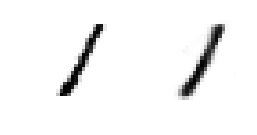

epoch:  58%|█████▊    | 116/200 [22:30<16:16, 11.63s/it]


Epoch 116 train_loss: 0.0611 val_loss 0.0622
loss 0.06109809061765671


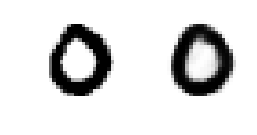

epoch:  58%|█████▊    | 117/200 [22:42<15:54, 11.50s/it]


Epoch 117 train_loss: 0.0611 val_loss 0.0621
loss 0.06111041486382485


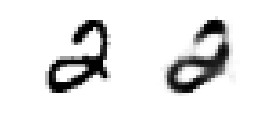

epoch:  59%|█████▉    | 118/200 [22:53<15:37, 11.43s/it]


Epoch 118 train_loss: 0.0611 val_loss 0.0622
loss 0.061071200790405275


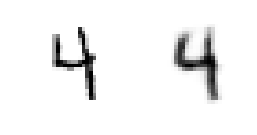

epoch:  60%|█████▉    | 119/200 [23:05<15:43, 11.65s/it]


Epoch 119 train_loss: 0.0611 val_loss 0.0622
loss 0.061020887160301206


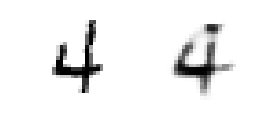

epoch:  60%|██████    | 120/200 [23:17<15:39, 11.74s/it]


Epoch 120 train_loss: 0.0610 val_loss 0.0622
loss 0.06094988634824753


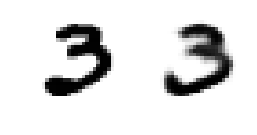

epoch:  60%|██████    | 121/200 [23:28<15:18, 11.62s/it]


Epoch 121 train_loss: 0.0609 val_loss 0.0624
loss 0.06093617354869842


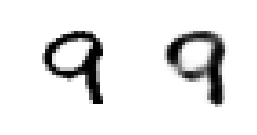

epoch:  61%|██████    | 122/200 [23:39<14:57, 11.50s/it]


Epoch 122 train_loss: 0.0609 val_loss 0.0620
loss 0.06086635404825211


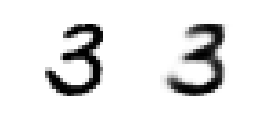

epoch:  62%|██████▏   | 123/200 [23:51<14:37, 11.40s/it]


Epoch 123 train_loss: 0.0609 val_loss 0.0622
loss 0.060944584980010985


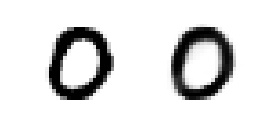

epoch:  62%|██████▏   | 124/200 [24:02<14:33, 11.50s/it]


Epoch 124 train_loss: 0.0609 val_loss 0.0622
loss 0.060858733603954315


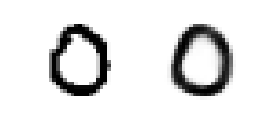

epoch:  62%|██████▎   | 125/200 [24:15<14:40, 11.74s/it]


Epoch 125 train_loss: 0.0609 val_loss 0.0621
loss 0.06082492233395576


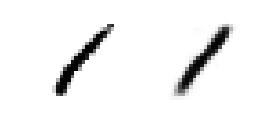

epoch:  63%|██████▎   | 126/200 [24:26<14:23, 11.67s/it]


Epoch 126 train_loss: 0.0608 val_loss 0.0623
loss 0.06082036761045456


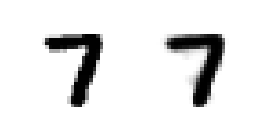

epoch:  64%|██████▎   | 127/200 [24:37<14:04, 11.57s/it]


Epoch 127 train_loss: 0.0608 val_loss 0.0617
loss 0.060719301953315735


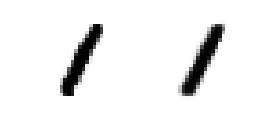

epoch:  64%|██████▍   | 128/200 [24:49<13:50, 11.53s/it]


Epoch 128 train_loss: 0.0607 val_loss 0.0620
loss 0.06069413696408272


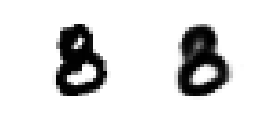

epoch:  64%|██████▍   | 129/200 [25:01<13:39, 11.54s/it]


Epoch 129 train_loss: 0.0607 val_loss 0.0619
loss 0.06067211698293686


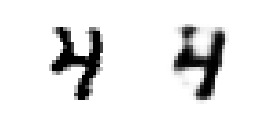

epoch:  65%|██████▌   | 130/200 [25:12<13:34, 11.64s/it]


Epoch 130 train_loss: 0.0607 val_loss 0.0619
loss 0.06065847109913826


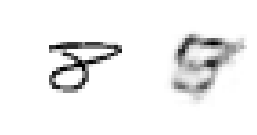

epoch:  66%|██████▌   | 131/200 [25:24<13:28, 11.72s/it]


Epoch 131 train_loss: 0.0607 val_loss 0.0617
loss 0.06061972967863083


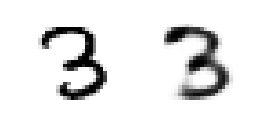

epoch:  66%|██████▌   | 132/200 [25:36<13:11, 11.63s/it]


Epoch 132 train_loss: 0.0606 val_loss 0.0617
loss 0.06060885306358337


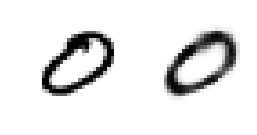

epoch:  66%|██████▋   | 133/200 [25:47<12:54, 11.55s/it]


Epoch 133 train_loss: 0.0606 val_loss 0.0617
loss 0.06054745988845825


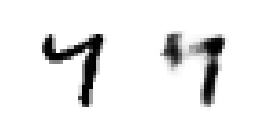

epoch:  67%|██████▋   | 134/200 [25:59<12:44, 11.58s/it]


Epoch 134 train_loss: 0.0605 val_loss 0.0617
loss 0.060533635807037356


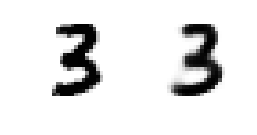

epoch:  68%|██████▊   | 135/200 [26:11<12:40, 11.70s/it]


Epoch 135 train_loss: 0.0605 val_loss 0.0620
loss 0.06051259445309639


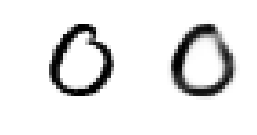

epoch:  68%|██████▊   | 136/200 [26:22<12:29, 11.71s/it]


Epoch 136 train_loss: 0.0605 val_loss 0.0616
loss 0.06044582637906074


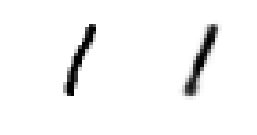

epoch:  68%|██████▊   | 137/200 [26:34<12:10, 11.60s/it]


Epoch 137 train_loss: 0.0604 val_loss 0.0618
loss 0.06044467857718468


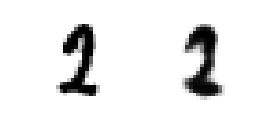

epoch:  69%|██████▉   | 138/200 [26:45<11:50, 11.45s/it]


Epoch 138 train_loss: 0.0604 val_loss 0.0614
loss 0.06043331876993179


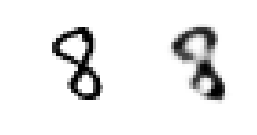

epoch:  70%|██████▉   | 139/200 [26:56<11:34, 11.38s/it]


Epoch 139 train_loss: 0.0604 val_loss 0.0616
loss 0.06034368330955505


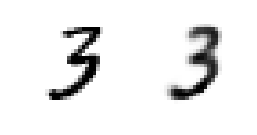

epoch:  70%|███████   | 140/200 [27:09<11:43, 11.72s/it]


Epoch 140 train_loss: 0.0603 val_loss 0.0614
loss 0.06033537347793579


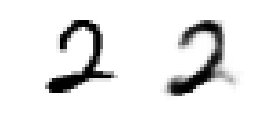

epoch:  70%|███████   | 141/200 [27:20<11:31, 11.71s/it]


Epoch 141 train_loss: 0.0603 val_loss 0.0614
loss 0.06025818234205246


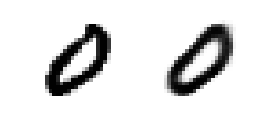

epoch:  71%|███████   | 142/200 [27:32<11:11, 11.57s/it]


Epoch 142 train_loss: 0.0603 val_loss 0.0612
loss 0.06020188438773155


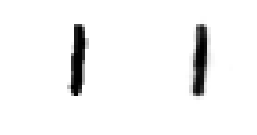

epoch:  72%|███████▏  | 143/200 [27:43<10:55, 11.50s/it]


Epoch 143 train_loss: 0.0602 val_loss 0.0613
loss 0.06020385937333107


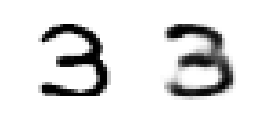

epoch:  72%|███████▏  | 144/200 [27:54<10:37, 11.39s/it]


Epoch 144 train_loss: 0.0602 val_loss 0.0616
loss 0.0601528572511673


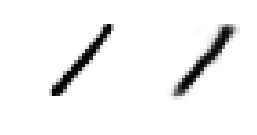

epoch:  72%|███████▎  | 145/200 [28:06<10:40, 11.64s/it]


Epoch 145 train_loss: 0.0602 val_loss 0.0613
loss 0.06008361001729965


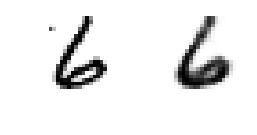

epoch:  73%|███████▎  | 146/200 [28:18<10:38, 11.82s/it]


Epoch 146 train_loss: 0.0601 val_loss 0.0610
loss 0.05999779720783233


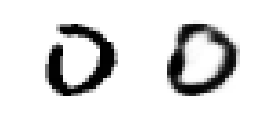

epoch:  74%|███████▎  | 147/200 [28:30<10:20, 11.70s/it]


Epoch 147 train_loss: 0.0600 val_loss 0.0613
loss 0.0599912305021286


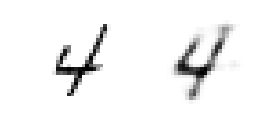

epoch:  74%|███████▍  | 148/200 [28:41<09:59, 11.53s/it]


Epoch 148 train_loss: 0.0600 val_loss 0.0611
loss 0.059914981390237806


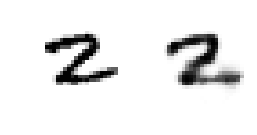

epoch:  74%|███████▍  | 149/200 [28:52<09:43, 11.44s/it]


Epoch 149 train_loss: 0.0599 val_loss 0.0610
loss 0.059899110765457154


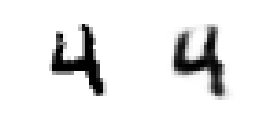

epoch:  75%|███████▌  | 150/200 [29:04<09:41, 11.62s/it]


Epoch 150 train_loss: 0.0599 val_loss 0.0610
loss 0.059812710230350494


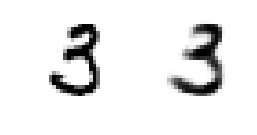

epoch:  76%|███████▌  | 151/200 [29:16<09:34, 11.73s/it]


Epoch 151 train_loss: 0.0598 val_loss 0.0612
loss 0.05980892754793167


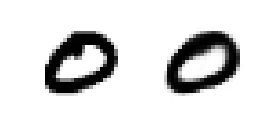

epoch:  76%|███████▌  | 152/200 [29:28<09:19, 11.66s/it]


Epoch 152 train_loss: 0.0598 val_loss 0.0608
loss 0.05978632061719894


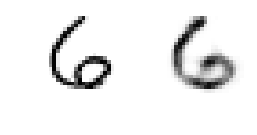

epoch:  76%|███████▋  | 153/200 [29:39<09:05, 11.60s/it]


Epoch 153 train_loss: 0.0598 val_loss 0.0609
loss 0.059776370549201964


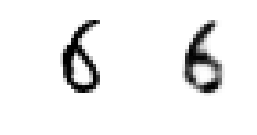

epoch:  77%|███████▋  | 154/200 [29:51<08:50, 11.54s/it]


Epoch 154 train_loss: 0.0598 val_loss 0.0607
loss 0.05968343299508095


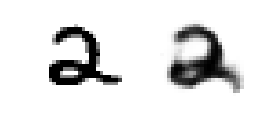

epoch:  78%|███████▊  | 155/200 [30:02<08:41, 11.58s/it]


Epoch 155 train_loss: 0.0597 val_loss 0.0609
loss 0.05965049819469452


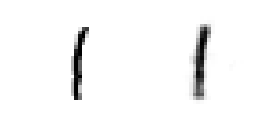

epoch:  78%|███████▊  | 156/200 [30:14<08:35, 11.71s/it]


Epoch 156 train_loss: 0.0597 val_loss 0.0608
loss 0.059687953052520754


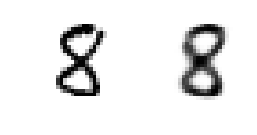

epoch:  78%|███████▊  | 157/200 [30:26<08:23, 11.70s/it]


Epoch 157 train_loss: 0.0597 val_loss 0.0608
loss 0.05963536270499229


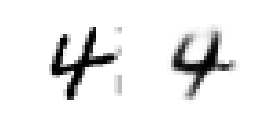

epoch:  79%|███████▉  | 158/200 [30:37<08:06, 11.59s/it]


Epoch 158 train_loss: 0.0596 val_loss 0.0611
loss 0.05961629151582718


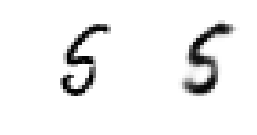

epoch:  80%|███████▉  | 159/200 [30:49<07:50, 11.47s/it]


Epoch 159 train_loss: 0.0596 val_loss 0.0608
loss 0.05959543153047562


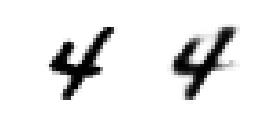

epoch:  80%|████████  | 160/200 [31:00<07:44, 11.61s/it]


Epoch 160 train_loss: 0.0596 val_loss 0.0607
loss 0.05957355572342873


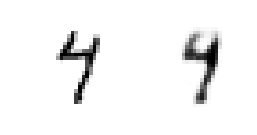

epoch:  80%|████████  | 161/200 [31:12<07:34, 11.66s/it]


Epoch 161 train_loss: 0.0596 val_loss 0.0607
loss 0.05950012936592102


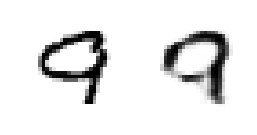

epoch:  81%|████████  | 162/200 [31:24<07:27, 11.78s/it]


Epoch 162 train_loss: 0.0595 val_loss 0.0605
loss 0.05950256512284279


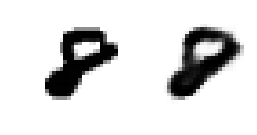

epoch:  82%|████████▏ | 163/200 [31:36<07:12, 11.70s/it]


Epoch 163 train_loss: 0.0595 val_loss 0.0605
loss 0.05947998594760895


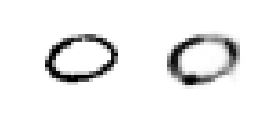

epoch:  82%|████████▏ | 164/200 [31:47<06:53, 11.50s/it]


Epoch 164 train_loss: 0.0595 val_loss 0.0607
loss 0.059422632238864896


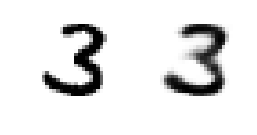

epoch:  82%|████████▎ | 165/200 [31:58<06:37, 11.37s/it]


Epoch 165 train_loss: 0.0594 val_loss 0.0608
loss 0.059400896433591845


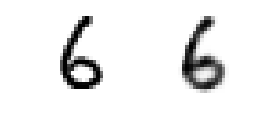

epoch:  83%|████████▎ | 166/200 [32:10<06:35, 11.65s/it]


Epoch 166 train_loss: 0.0594 val_loss 0.0605
loss 0.05939492268323898


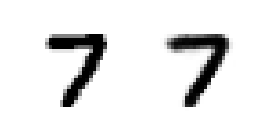

epoch:  84%|████████▎ | 167/200 [32:22<06:25, 11.67s/it]


Epoch 167 train_loss: 0.0594 val_loss 0.0606
loss 0.05936879683971405


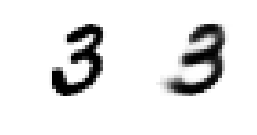

epoch:  84%|████████▍ | 168/200 [32:33<06:08, 11.51s/it]


Epoch 168 train_loss: 0.0594 val_loss 0.0604
loss 0.059369654483795165


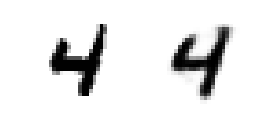

epoch:  84%|████████▍ | 169/200 [32:44<05:54, 11.43s/it]


Epoch 169 train_loss: 0.0594 val_loss 0.0604
loss 0.05930709492325783


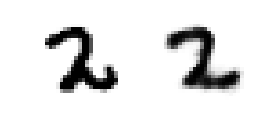

epoch:  85%|████████▌ | 170/200 [32:55<05:40, 11.35s/it]


Epoch 170 train_loss: 0.0593 val_loss 0.0605
loss 0.05928228626012802


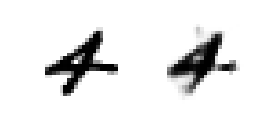

epoch:  86%|████████▌ | 171/200 [33:08<05:35, 11.56s/it]


Epoch 171 train_loss: 0.0593 val_loss 0.0607
loss 0.05929225800871849


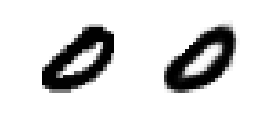

epoch:  86%|████████▌ | 172/200 [33:20<05:27, 11.71s/it]


Epoch 172 train_loss: 0.0593 val_loss 0.0605
loss 0.059245194187164306


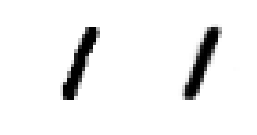

epoch:  86%|████████▋ | 173/200 [33:31<05:14, 11.64s/it]


Epoch 173 train_loss: 0.0592 val_loss 0.0607
loss 0.05922059253454209


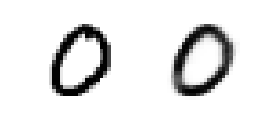

epoch:  87%|████████▋ | 174/200 [33:42<04:58, 11.50s/it]


Epoch 174 train_loss: 0.0592 val_loss 0.0604
loss 0.059175157339572904


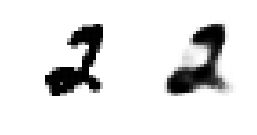

epoch:  88%|████████▊ | 175/200 [33:53<04:43, 11.36s/it]


Epoch 175 train_loss: 0.0592 val_loss 0.0604
loss 0.05919442672729492


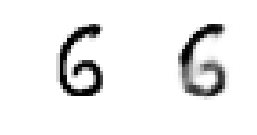

epoch:  88%|████████▊ | 176/200 [34:05<04:38, 11.60s/it]


Epoch 176 train_loss: 0.0592 val_loss 0.0602
loss 0.05917030079007149


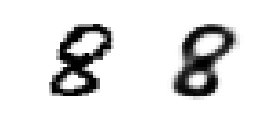

epoch:  88%|████████▊ | 177/200 [34:17<04:26, 11.61s/it]


Epoch 177 train_loss: 0.0592 val_loss 0.0602
loss 0.059134088871479036


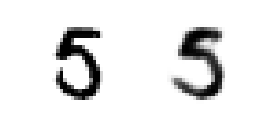

epoch:  89%|████████▉ | 178/200 [34:28<04:13, 11.54s/it]


Epoch 178 train_loss: 0.0591 val_loss 0.0606
loss 0.05915552685379982


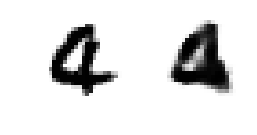

epoch:  90%|████████▉ | 179/200 [34:40<04:01, 11.52s/it]


Epoch 179 train_loss: 0.0592 val_loss 0.0605
loss 0.05908326834201813


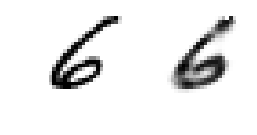

epoch:  90%|█████████ | 180/200 [34:51<03:47, 11.39s/it]


Epoch 180 train_loss: 0.0591 val_loss 0.0604
loss 0.059046993848085406


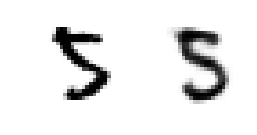

epoch:  90%|█████████ | 181/200 [35:03<03:39, 11.53s/it]


Epoch 181 train_loss: 0.0590 val_loss 0.0603
loss 0.05907689254999161


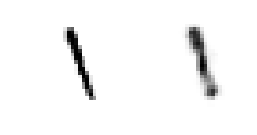

epoch:  91%|█████████ | 182/200 [35:15<03:30, 11.72s/it]


Epoch 182 train_loss: 0.0591 val_loss 0.0604
loss 0.05908039679169655


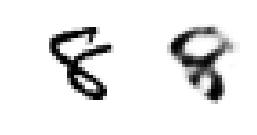

epoch:  92%|█████████▏| 183/200 [35:26<03:17, 11.61s/it]


Epoch 183 train_loss: 0.0591 val_loss 0.0603
loss 0.05899692316174507


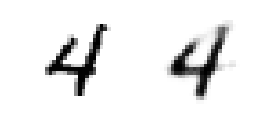

epoch:  92%|█████████▏| 184/200 [35:38<03:03, 11.48s/it]


Epoch 184 train_loss: 0.0590 val_loss 0.0601
loss 0.05901095180988312


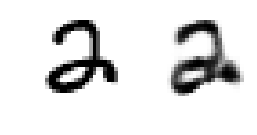

epoch:  92%|█████████▎| 185/200 [35:49<02:52, 11.52s/it]


Epoch 185 train_loss: 0.0590 val_loss 0.0601
loss 0.058975624064207074


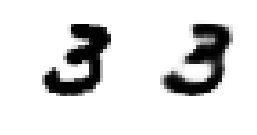

epoch:  93%|█████████▎| 186/200 [36:01<02:41, 11.56s/it]


Epoch 186 train_loss: 0.0590 val_loss 0.0604
loss 0.058990541133880615


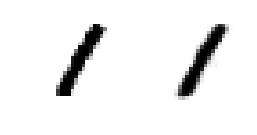

epoch:  94%|█████████▎| 187/200 [36:13<02:31, 11.69s/it]


Epoch 187 train_loss: 0.0590 val_loss 0.0600
loss 0.05889883589029312


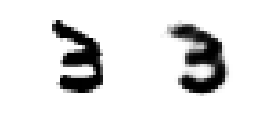

epoch:  94%|█████████▍| 188/200 [36:25<02:21, 11.78s/it]


Epoch 188 train_loss: 0.0589 val_loss 0.0601
loss 0.05898494611978531


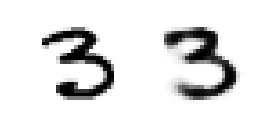

epoch:  94%|█████████▍| 189/200 [36:36<02:07, 11.60s/it]


Epoch 189 train_loss: 0.0590 val_loss 0.0604
loss 0.05891411983132362


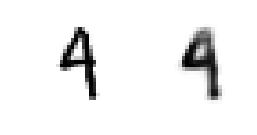

epoch:  95%|█████████▌| 190/200 [36:47<01:54, 11.50s/it]


Epoch 190 train_loss: 0.0589 val_loss 0.0601
loss 0.058882619692087176


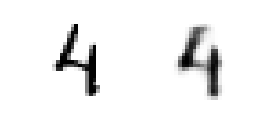

epoch:  96%|█████████▌| 191/200 [36:59<01:44, 11.57s/it]


Epoch 191 train_loss: 0.0589 val_loss 0.0602
loss 0.05885927519083023


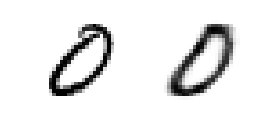

epoch:  96%|█████████▌| 192/200 [37:11<01:33, 11.64s/it]


Epoch 192 train_loss: 0.0589 val_loss 0.0603
loss 0.0589046094584465


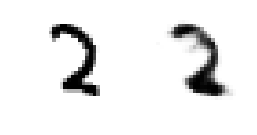

epoch:  96%|█████████▋| 193/200 [37:23<01:21, 11.70s/it]


Epoch 193 train_loss: 0.0589 val_loss 0.0604
loss 0.05882606654763222


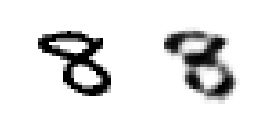

epoch:  97%|█████████▋| 194/200 [37:34<01:09, 11.63s/it]


Epoch 194 train_loss: 0.0588 val_loss 0.0601
loss 0.05880144131183624


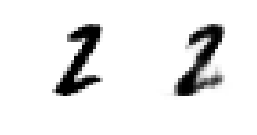

epoch:  98%|█████████▊| 195/200 [37:45<00:57, 11.52s/it]


Epoch 195 train_loss: 0.0588 val_loss 0.0601
loss 0.05878689854979515


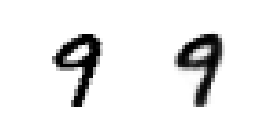

epoch:  98%|█████████▊| 196/200 [37:57<00:45, 11.42s/it]


Epoch 196 train_loss: 0.0588 val_loss 0.0598
loss 0.05877022854566574


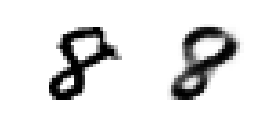

epoch:  98%|█████████▊| 197/200 [38:09<00:35, 11.68s/it]


Epoch 197 train_loss: 0.0588 val_loss 0.0603
loss 0.05876806071996689


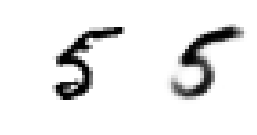

epoch:  99%|█████████▉| 198/200 [38:21<00:23, 11.70s/it]


Epoch 198 train_loss: 0.0588 val_loss 0.0604
loss 0.058745717653036114


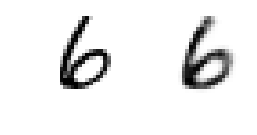

epoch: 100%|█████████▉| 199/200 [38:32<00:11, 11.67s/it]


Epoch 199 train_loss: 0.0587 val_loss 0.0599
loss 0.05874543891429901


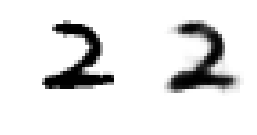

epoch: 100%|██████████| 200/200 [38:44<00:00, 11.62s/it]


Epoch 200 train_loss: 0.0587 val_loss 0.0599


In [10]:
history = train(train_dataset, val_dataset, model=model, epochs=200, batch_size=128, is_cvae=False)

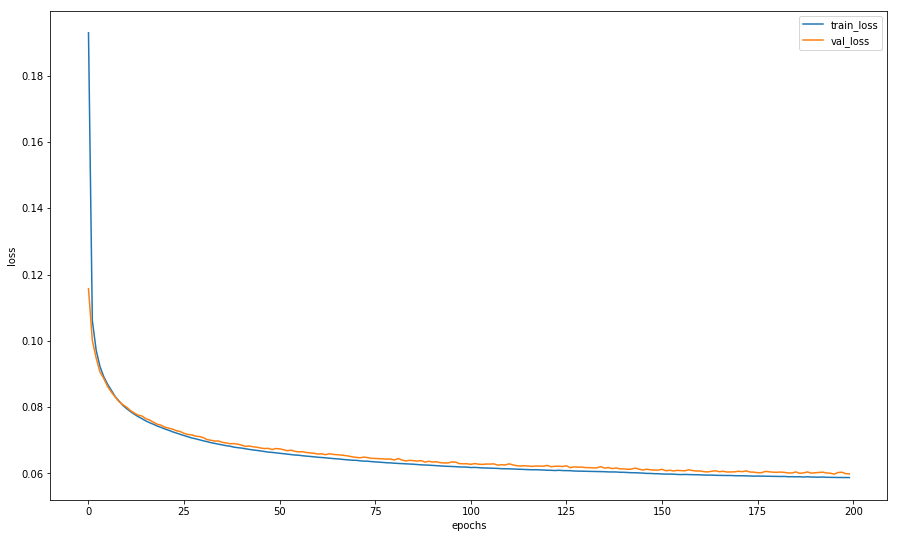

In [11]:
plot_loss(history)

# Sampling

Now we can try to get not the random pictures, but the numbers we want to generate. Let's say numbers from 0 to 9.

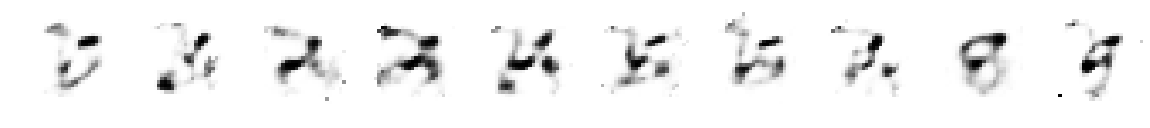

In [12]:
with torch.set_grad_enabled(False):
    number_for_generation=[0,1,2,3,4,5,6,7,8,9]
    inputs = torch.FloatTensor(np.random.randn(10*28*28).reshape(-1,28,28))
    inputs = inputs.to(DEVICE)
    label = one_hot(number_for_generation,9).to(DEVICE)
    outputs = model(inputs,label)
    plot_gallery(outputs.cpu(),28,28,1,10)

# Exploring the latent space using t-SNE

t-Distributed Stochastic Neighbor Embedding (t-SNE) is a technique for dimensionality reduction that is particularly well suited for the visualization of high-dimensional datasets. Let's use it and plot the results.

In [13]:
def get_latent_data(net, count=1000, is_cvae=False):
    latent_vectors = []
    latent_labels = []
    img_inputs = []
    rounds = count/100
    i=0
    with torch.set_grad_enabled(False):
        dataset_loader = DataLoader(dataset, batch_size=100, shuffle=True)
        for inputs,labels in dataset_loader:
            inputs = inputs.to(DEVICE)
            labels_one_hot = one_hot(labels,9).to(DEVICE)
            if is_cvae:
                outputs, mu, logvar = net(inputs,labels_one_hot)
            else:
                outputs = net(inputs,labels_one_hot)
            outputs = outputs.cpu()
            if i==0:
              latent_vectors = outputs
              latent_labels = labels
              img_inputs = inputs
            else:
              latent_vectors = torch.cat((latent_vectors,outputs),0)
              latent_labels = torch.cat((latent_labels,labels),0)
              img_inputs = torch.cat((img_inputs,inputs),0)
            if i>rounds:
              break
            i+=1
    return img_inputs, latent_vectors, latent_labels

def plot_tsne(net, mode, count, is_cvae=False):
    img_inputs,latent_vectors,latent_labels = get_latent_data(net=net, count=count, is_cvae=is_cvae)
    fig, ax = plt.subplots(figsize=(10, 7))
    ax.set_title('t-SNE')
    coords = TSNE(n_components=2,random_state=42).fit_transform(latent_vectors)
    if mode == 'imgs':
        for image, (x, y) in zip(img_inputs.cpu(), coords):
            im = OffsetImage(image.reshape(28, 28), zoom=1, cmap='gray')
            ab = AnnotationBbox(im, (x, y), xycoords='data', frameon=False)
            ax.add_artist(ab)
        ax.update_datalim(coords)
        ax.autoscale()
    elif mode == 'dots':
        classes = latent_labels
        plt.scatter(coords[:, 0], coords[:, 1], c=classes)
        plt.colorbar()
        for i in range(10):
            class_center = np.mean(coords[classes == i], axis=0)
            text = TextArea('{}'.format(i))
            ab = AnnotationBbox(text, class_center, xycoords='data', frameon=True)
            ax.add_artist(ab)
    plt.show()

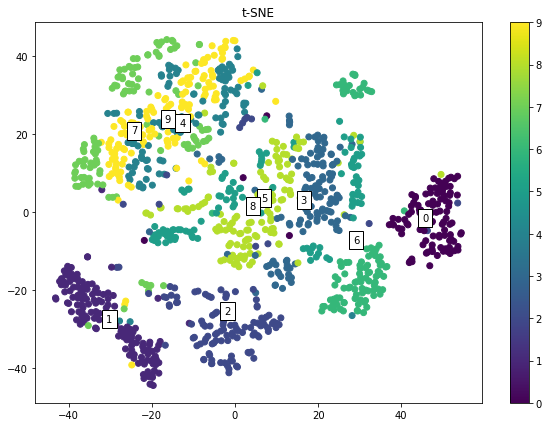

In [14]:
plot_tsne(net=model, mode='dots', count=1000)

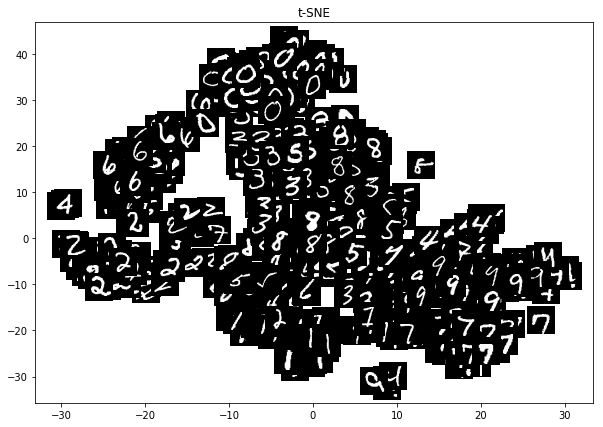

In [15]:
plot_tsne(net=model, mode='imgs', count=300)

# Conditional Variational Autoencoder

In [16]:
class CVAE(nn.Module):
    def __init__(self, input_size, hidden_size=20):
        super(CVAE, self).__init__()
        input_size_with_label = input_size + labels_length
        hidden_size += labels_length
        
        self.fc1 = nn.Linear(input_size_with_label,512)
        self.fc21 = nn.Linear(512, hidden_size)
        self.fc22 = nn.Linear(512, hidden_size)
        
        self.relu = nn.ReLU()
        
        self.fc3 = nn.Linear(hidden_size, 512)
        self.fc4 = nn.Linear(512, input_size)
    
    def encode(self, x, labels):
        x = x.view(-1, 1*28*28)
        x = torch.cat((x, labels), 1)
        x = self.relu(self.fc1(x))
        return self.fc21(x), self.fc22(x)
        
    def decode(self, z, labels):
        torch.cat((z, labels), 1)
        z = self.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(z))
        
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 *logvar)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)
        
    def forward(self,x, labels):
        #targets = one_hot(targets,labels_length-1).float().to(DEVICE)
        mu, logvar = self.encode(x, labels)
        z = self.reparameterize(mu, logvar)
        x = self.decode(z, labels)
        return x, mu, logvar

def train_cvae(net, dataloader, test_dataloader, flatten=True, epochs=20):
    validation_losses = []
    optim = torch.optim.Adam(net.parameters())

    log_template = "\nEpoch {ep:03d} val_loss {v_loss:0.4f}"
    with tqdm(desc="epoch", total=epochs) as pbar_outer:  
        for i in range(epochs):
            for batch, labels in dataloader:
                batch = batch.to(DEVICE)
                labels = one_hot(labels,9).to(DEVICE)

                if flatten:
                    batch = batch.view(batch.size(0), 28*28)

                optim.zero_grad()
                x,mu,logvar = net(batch, labels)
                loss = vae_loss_fn(batch, x[:, :784], mu, logvar)
                loss.backward()
                optim.step()
            evaluate(validation_losses, net, test_dataloader, flatten=True)
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=i+1, v_loss=validation_losses[i]))
    plt.show()
    return validation_losses

In [17]:
cvae = CVAE(28*28).to(DEVICE)

In [18]:
def vae_loss_fn(x, recon_x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

def evaluate(losses, autoencoder, dataloader, flatten=True):
    model = lambda x, y: autoencoder(x, y)[0]    
    loss_sum = []
    inp, out = [],[]
    loss_fn = nn.MSELoss()
    for inputs, labels in dataloader:
        inputs = inputs.to(DEVICE)
        labels = one_hot(labels,9).to(DEVICE)

        if flatten:
            inputs = inputs.view(inputs.size(0), 28*28)

        outputs = model(inputs, labels)
        loss = loss_fn(inputs, outputs)            
        loss_sum.append(loss)
        inp = inputs
        out = outputs

    with torch.set_grad_enabled(False):
        plot_gallery([inp[0].detach().cpu(),out[0].detach().cpu()],28,28,1,2)    

    losses.append((sum(loss_sum)/len(loss_sum)).item())

In [19]:
def train_cvae(net, dataloader, test_dataloader, flatten=True, epochs=50):
    validation_losses = []
    optim = torch.optim.Adam(net.parameters())

    log_template = "\nEpoch {ep:03d} val_loss {v_loss:0.4f}"
    with tqdm(desc="epoch", total=epochs) as pbar_outer:  
        for i in range(epochs):
            for batch, labels in dataloader:
                batch = batch.to(DEVICE)
                labels = one_hot(labels,9).to(DEVICE)

                if flatten:
                    batch = batch.view(batch.size(0), 28*28)

                optim.zero_grad()
                x,mu,logvar = net(batch, labels)
                loss = vae_loss_fn(batch, x[:, :784], mu, logvar)
                loss.backward()
                optim.step()
            evaluate(validation_losses, net, test_dataloader, flatten=True)
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=i+1, v_loss=validation_losses[i]))
    plt.show()
    return validation_losses

epoch:   0%|          | 0/50 [00:00<?, ?it/s]

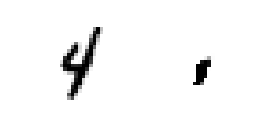

epoch:   2%|▏         | 1/50 [00:12<10:16, 12.57s/it]


Epoch 001 val_loss 0.9116


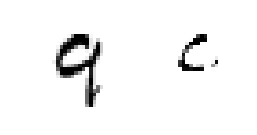

epoch:   4%|▍         | 2/50 [00:24<09:54, 12.38s/it]


Epoch 002 val_loss 0.8905


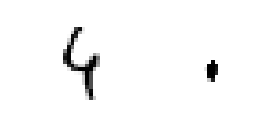

epoch:   6%|▌         | 3/50 [00:36<09:33, 12.20s/it]


Epoch 003 val_loss 0.8806


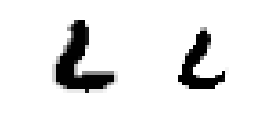

epoch:   8%|▊         | 4/50 [00:48<09:16, 12.11s/it]


Epoch 004 val_loss 0.8740


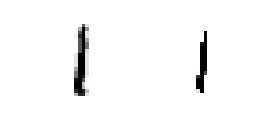

epoch:  10%|█         | 5/50 [01:00<09:11, 12.26s/it]


Epoch 005 val_loss 0.8680


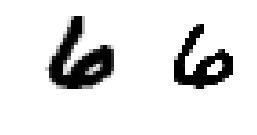

epoch:  12%|█▏        | 6/50 [01:13<09:01, 12.30s/it]


Epoch 006 val_loss 0.8661


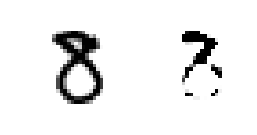

epoch:  14%|█▍        | 7/50 [01:25<08:48, 12.29s/it]


Epoch 007 val_loss 0.8654


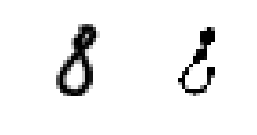

epoch:  16%|█▌        | 8/50 [01:37<08:28, 12.12s/it]


Epoch 008 val_loss 0.8628


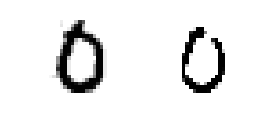

epoch:  18%|█▊        | 9/50 [01:48<08:12, 12.01s/it]


Epoch 009 val_loss 0.8604


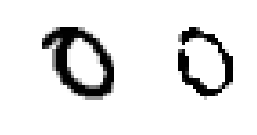

epoch:  20%|██        | 10/50 [02:01<08:07, 12.18s/it]


Epoch 010 val_loss 0.8605


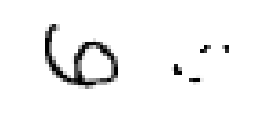

epoch:  22%|██▏       | 11/50 [02:13<07:58, 12.26s/it]


Epoch 011 val_loss 0.8586


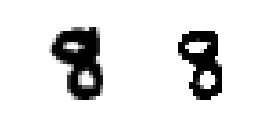

epoch:  24%|██▍       | 12/50 [02:25<07:42, 12.16s/it]


Epoch 012 val_loss 0.8578


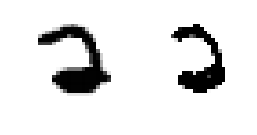

epoch:  26%|██▌       | 13/50 [02:37<07:25, 12.04s/it]


Epoch 013 val_loss 0.8586


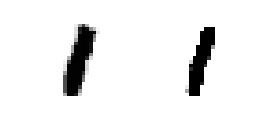

epoch:  28%|██▊       | 14/50 [02:49<07:09, 11.93s/it]


Epoch 014 val_loss 0.8569


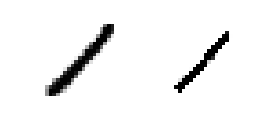

epoch:  30%|███       | 15/50 [03:02<07:07, 12.22s/it]


Epoch 015 val_loss 0.8562


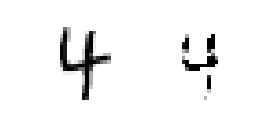

epoch:  32%|███▏      | 16/50 [03:14<06:56, 12.24s/it]


Epoch 016 val_loss 0.8563


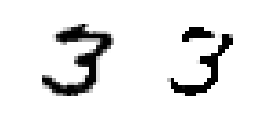

epoch:  34%|███▍      | 17/50 [03:26<06:40, 12.13s/it]


Epoch 017 val_loss 0.8543


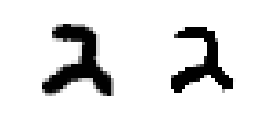

epoch:  36%|███▌      | 18/50 [03:38<06:24, 12.01s/it]


Epoch 018 val_loss 0.8546


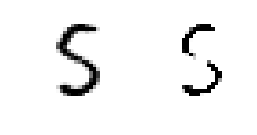

epoch:  38%|███▊      | 19/50 [03:49<06:11, 11.97s/it]


Epoch 019 val_loss 0.8542


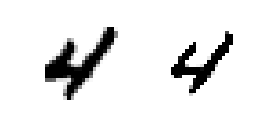

epoch:  40%|████      | 20/50 [04:02<06:06, 12.23s/it]


Epoch 020 val_loss 0.8541


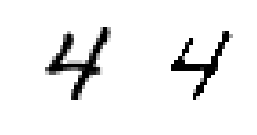

epoch:  42%|████▏     | 21/50 [04:15<05:55, 12.24s/it]


Epoch 021 val_loss 0.8534


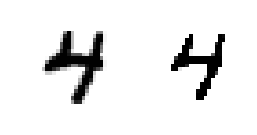

epoch:  44%|████▍     | 22/50 [04:26<05:39, 12.13s/it]


Epoch 022 val_loss 0.8533


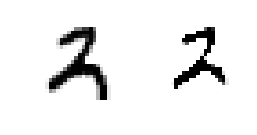

epoch:  46%|████▌     | 23/50 [04:38<05:26, 12.09s/it]


Epoch 023 val_loss 0.8533


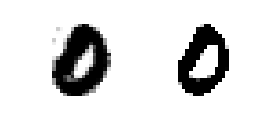

epoch:  48%|████▊     | 24/50 [04:50<05:12, 12.04s/it]


Epoch 024 val_loss 0.8538


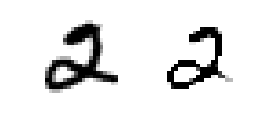

epoch:  50%|█████     | 25/50 [05:03<05:08, 12.33s/it]


Epoch 025 val_loss 0.8532


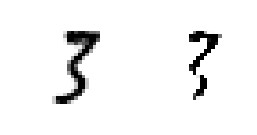

epoch:  52%|█████▏    | 26/50 [05:16<04:56, 12.34s/it]


Epoch 026 val_loss 0.8532


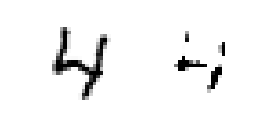

epoch:  54%|█████▍    | 27/50 [05:28<04:41, 12.23s/it]


Epoch 027 val_loss 0.8535


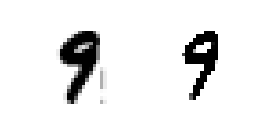

epoch:  56%|█████▌    | 28/50 [05:40<04:26, 12.13s/it]


Epoch 028 val_loss 0.8536


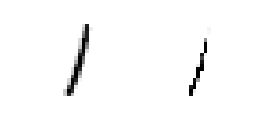

epoch:  58%|█████▊    | 29/50 [05:52<04:13, 12.06s/it]


Epoch 029 val_loss 0.8525


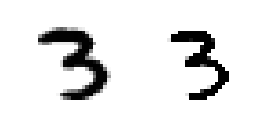

epoch:  60%|██████    | 30/50 [06:04<04:06, 12.33s/it]


Epoch 030 val_loss 0.8528


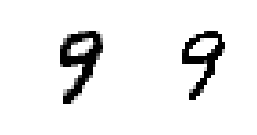

epoch:  62%|██████▏   | 31/50 [06:17<03:53, 12.31s/it]


Epoch 031 val_loss 0.8522


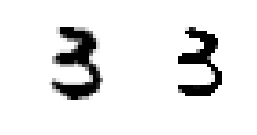

epoch:  64%|██████▍   | 32/50 [06:29<03:39, 12.19s/it]


Epoch 032 val_loss 0.8526


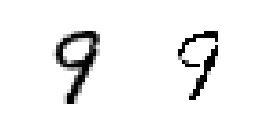

epoch:  66%|██████▌   | 33/50 [06:40<03:25, 12.09s/it]


Epoch 033 val_loss 0.8532


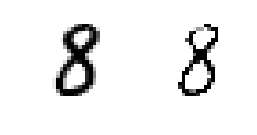

epoch:  68%|██████▊   | 34/50 [06:52<03:12, 12.05s/it]


Epoch 034 val_loss 0.8519


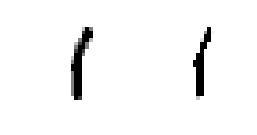

epoch:  70%|███████   | 35/50 [07:06<03:05, 12.36s/it]


Epoch 035 val_loss 0.8519


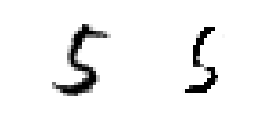

epoch:  72%|███████▏  | 36/50 [07:18<02:52, 12.34s/it]


Epoch 036 val_loss 0.8522


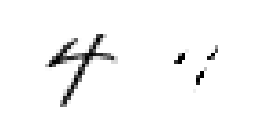

epoch:  74%|███████▍  | 37/50 [07:30<02:38, 12.22s/it]


Epoch 037 val_loss 0.8524


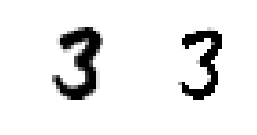

epoch:  76%|███████▌  | 38/50 [07:42<02:25, 12.09s/it]


Epoch 038 val_loss 0.8518


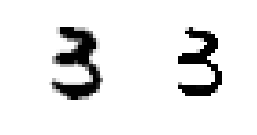

epoch:  78%|███████▊  | 39/50 [07:53<02:11, 11.98s/it]


Epoch 039 val_loss 0.8520


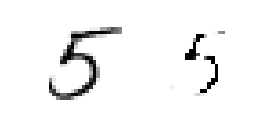

epoch:  80%|████████  | 40/50 [08:06<02:03, 12.33s/it]


Epoch 040 val_loss 0.8514


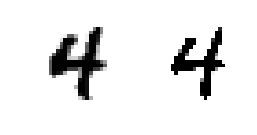

epoch:  82%|████████▏ | 41/50 [08:19<01:50, 12.29s/it]


Epoch 041 val_loss 0.8513


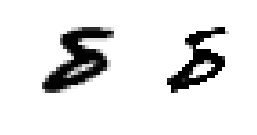

epoch:  84%|████████▍ | 42/50 [08:30<01:36, 12.09s/it]


Epoch 042 val_loss 0.8523


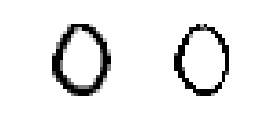

epoch:  86%|████████▌ | 43/50 [08:42<01:24, 12.08s/it]


Epoch 043 val_loss 0.8512


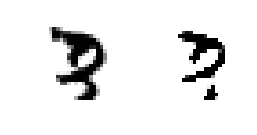

epoch:  88%|████████▊ | 44/50 [08:55<01:13, 12.19s/it]


Epoch 044 val_loss 0.8521


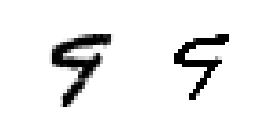

epoch:  90%|█████████ | 45/50 [09:07<01:01, 12.22s/it]


Epoch 045 val_loss 0.8519


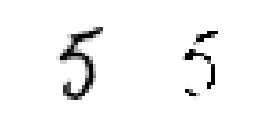

epoch:  92%|█████████▏| 46/50 [09:19<00:49, 12.26s/it]


Epoch 046 val_loss 0.8511


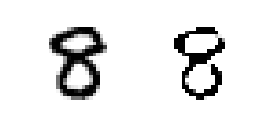

epoch:  94%|█████████▍| 47/50 [09:31<00:36, 12.08s/it]


Epoch 047 val_loss 0.8515


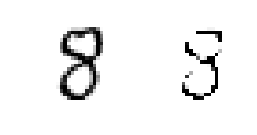

epoch:  96%|█████████▌| 48/50 [09:43<00:23, 11.97s/it]


Epoch 048 val_loss 0.8508


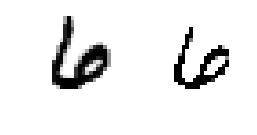

epoch:  98%|█████████▊| 49/50 [09:55<00:12, 12.06s/it]


Epoch 049 val_loss 0.8515


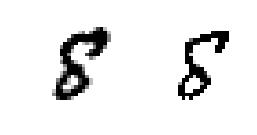

epoch: 100%|██████████| 50/50 [10:07<00:00, 12.16s/it]


Epoch 050 val_loss 0.8521


In [20]:
history = train_cvae(cvae, train_dataset, val_dataset)

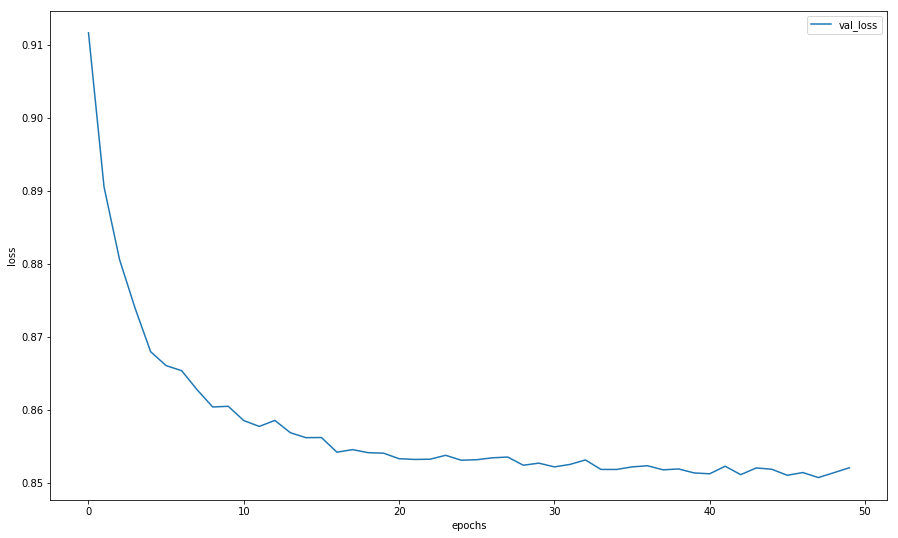

In [21]:
val_loss = history
plt.figure(figsize=(15, 9))
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

# Plotting CVAE latent space using t-SNE

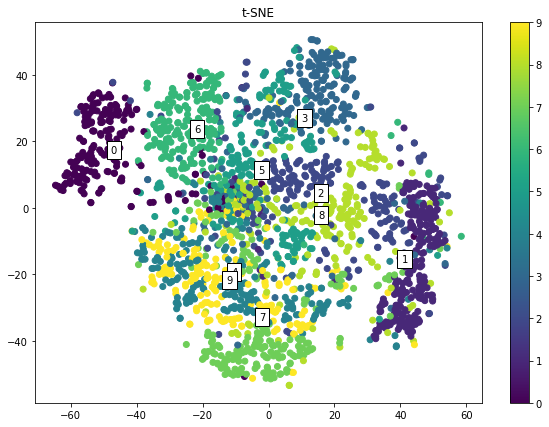

In [22]:
plot_tsne(net=cvae, mode='dots', count=2000, is_cvae=True)

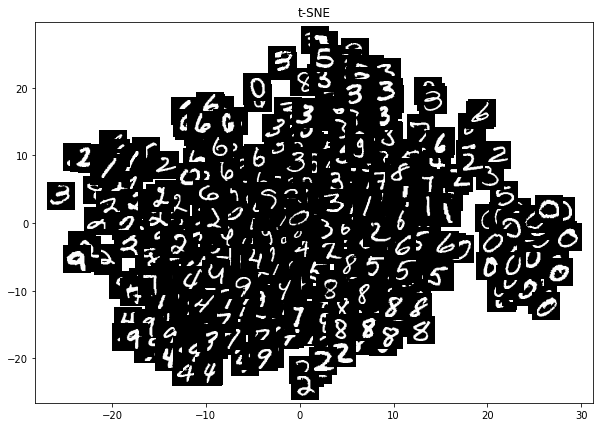

In [23]:
plot_tsne(net=cvae, mode='imgs', count=300, is_cvae=True)

# Conclusion

Optimizing both **reconstruction** loss and **KL divergence** loss together results in the generation of a latent space which maintains the similarity of nearby encodings on the local scale via clustering, yet globally, is very densely packed near the latent space origin (compare the axes with the original).

Cool pic:

![https://media.giphy.com/media/lqq0em9cuivVNWFwSX/giphy.gif](https://media.giphy.com/media/lqq0em9cuivVNWFwSX/giphy.gif)